# Final Project 

## Group Member

## Yuan Zhang, yz3455

## Zhuting Jiang, zj2245

In [90]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import os
import pylab as plt
import numpy as np
import seaborn
import math
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
#import datetime
#import calendar

pd.set_option('display.max_columns', 500)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/fizz/Downloads/FinalProject_MapPredictions/My First Project-8b6f59970d18.json"

## Import Data#

We get data directly from Big Query: `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`.

We delete some outlers such as distance over 1000 miles, and the pickup/ dropoff location out of longtitude -73.6977 to -74.2565 and latitude from 40.4950 to 40.9105(Based on the range of NYC, goole map). We have travel distance, some features of location and weathers.

### NYC map
https://www.google.com/maps/place/New+York,+NY/data=!4m2!3m1!1s0x89c24fa5d33f083b:0xc80b8f06e177fe62?sa=X&ved=2ahUKEwihiLLxtZ_iAhXKl-AKHeQ0CgwQ8gEwAHoECAoQAQ

In [91]:
query = (
    """
    SELECT * FROM 
    (
    SELECT *,
    DATETIME_DIFF( dropoff_datetime, pickup_datetime, SECOND) as travel_time,
     EXTRACT (DATE FROM pickup_datetime) as date_of_year,
     EXTRACT (DAY FROM pickup_datetime) as day,
     EXTRACT (MONTH FROM pickup_datetime) as month
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016` where trip_distance < 1000 
    and pickup_longitude > -74.2565 and pickup_longitude < -73.6977 and dropoff_longitude > -74.2565 and 
    dropoff_longitude < -73.6977 and pickup_latitude < 40.9105 and pickup_latitude > 40.4950 and 
    dropoff_latitude < 40.9105 and dropoff_latitude > 40.4950) a 
    INNER JOIN
    (
     select concat(year,'-',mo,'-',da) as date_of_year2,year,mo,da,temp,visib,wdsp,gust,max,
     min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
     from `bigquery-public-data.noaa_gsod.gsod2016` where stn='725053'
    ) weather_data
    on CAST(a.date_of_year AS STRING) = weather_data.date_of_year2
    ORDER BY RAND()
    LIMIT 1000000"""
)
df=pd.io.gbq.read_gbq(query,dialect='standard')



In [92]:
df.head(10)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,travel_time,date_of_year,day,month,date_of_year2,year,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
0,2,2016-06-01 08:02:23,2016-06-01 08:03:41,1,0.25,-73.956177,40.781719,1,N,-73.953629,40.785149,2,3.0,0.0,0.5,0.00,0.00,0.3,3.80,78,2016-06-01,1,6,2016-06-01,2016,06,01,75.3,8.3,4.6,999.9,84.9,69.1,0.00,999.9,0,0,0,0,0
1,1,2016-04-08 00:57:37,2016-04-08 01:02:09,1,0.70,-74.009544,40.738129,1,N,-73.998238,40.740978,2,5.0,0.5,0.5,0.00,0.00,0.3,6.30,272,2016-04-08,8,4,2016-04-08,2016,04,08,47.3,10.0,6.7,25.1,57.9,42.1,0.09,999.9,0,0,0,0,0
2,2,2016-02-02 22:57:49,2016-02-02 23:06:54,1,2.21,-73.979584,40.771179,1,N,-73.952744,40.780579,2,9.5,0.5,0.5,0.00,0.00,0.3,10.80,545,2016-02-02,2,2,2016-02-02,2016,02,02,44.5,10.0,3.4,999.9,59.0,37.9,0.01,2.0,0,0,0,0,0
3,1,2016-04-26 09:21:41,2016-04-26 09:45:22,1,1.90,-73.963181,40.762638,1,N,-73.988884,40.757198,1,15.0,0.0,0.5,3.16,0.00,0.3,18.96,1421,2016-04-26,26,4,2016-04-26,2016,04,26,54.9,6.8,5.2,15.9,69.1,48.9,0.17,999.9,0,1,0,0,0
4,1,2016-02-10 06:04:56,2016-02-10 06:06:53,1,0.50,-73.967049,40.761204,1,N,-73.961456,40.765320,2,3.5,0.0,0.5,0.00,0.00,0.3,4.30,117,2016-02-10,10,2,2016-02-10,2016,02,10,34.8,7.5,3.8,20.0,39.0,27.0,0.01,999.9,0,0,1,0,0
5,1,2016-01-18 13:37:01,2016-01-18 13:43:13,4,1.20,-73.977806,40.786533,1,N,-73.981483,40.774338,1,6.0,0.0,0.5,1.20,0.00,0.3,8.00,372,2016-01-18,18,1,2016-01-18,2016,01,18,27.1,8.9,7.5,28.9,42.1,21.9,0.05,999.9,0,0,1,0,0
6,1,2016-05-05 07:09:16,2016-05-05 07:14:21,1,0.90,-73.960205,40.766293,1,N,-73.970093,40.759586,1,5.5,0.0,0.5,1.00,0.00,0.3,7.30,305,2016-05-05,5,5,2016-05-05,2016,05,05,50.9,9.5,7.5,18.1,57.0,46.0,0.01,999.9,0,0,0,0,0
7,1,2016-03-17 19:51:54,2016-03-17 19:58:02,1,1.20,-73.983826,40.743633,1,N,-73.971779,40.756119,1,6.5,1.0,0.5,1.65,0.00,0.3,9.95,368,2016-03-17,17,3,2016-03-17,2016,03,17,52.0,9.8,4.4,22.0,64.9,45.0,0.02,999.9,0,0,0,0,0
8,1,2016-04-27 23:48:05,2016-04-28 00:02:02,1,5.10,-73.975540,40.761608,1,N,-73.958473,40.815800,1,17.5,0.5,0.5,3.75,0.00,0.3,22.55,837,2016-04-27,27,4,2016-04-27,2016,04,27,51.3,9.8,4.3,15.9,62.1,46.0,0.07,999.9,0,0,0,0,0
9,1,2016-01-06 02:13:09,2016-01-06 02:49:04,4,17.50,-73.984734,40.760338,2,N,-73.805359,40.661221,2,52.0,0.0,0.5,0.00,5.54,0.3,58.34,2155,2016-01-06,6,1,2016-01-06,2016,01,06,31.2,10.0,2.4,999.9,41.0,10.9,0.00,999.9,0,0,0,0,0


# Integrity of Data

In [93]:
#Check NA's of categorical variables

check = []
col = ['year','fog','rain_drizzle','snow_ice_pellets','hail','thunder']

for i in col:
    check.append(df[i].unique())

check = pd.DataFrame([check],columns=col)
check

,year,fog,rain_drizzle,snow_ice_pellets,hail,thunder
0,[2016],"[0, 1]","[0, 1]","[0, 1]",[0],[0]


In [94]:
#Check 0's

check = []

for i in df.columns:
    check.append(df[i].isnull().any())

check = pd.DataFrame([check],columns=df.columns)
sum(check.values)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Filter outliers for travel distance ##

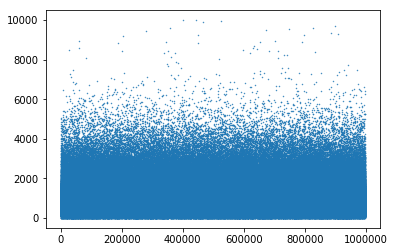

In [95]:
travel = df[["travel_time"]].values
travel1 = travel[travel<10000]
sum(travel==0)
plt.scatter(np.linspace(1,travel1.shape[0],travel1.shape[0]),travel1,s=0.2)

In [96]:
df1 = df[df["travel_time"] < 10000]

## Travel Distance ##

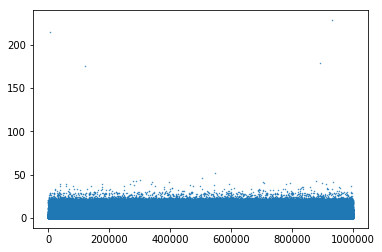

In [97]:
T_distance = df1[["trip_distance"]].values
# check distribution, find outlier
plt.scatter(np.linspace(1,T_distance.shape[0],T_distance.shape[0]),T_distance,s=0.2)

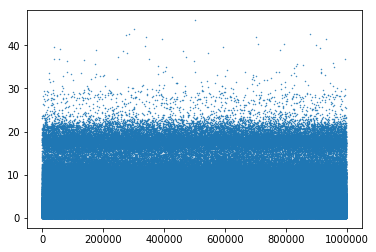

In [98]:
df2 = df1[df1["trip_distance"]< 50]
T_distance = df2[["trip_distance"]].values
plt.scatter(np.linspace(1,T_distance.shape[0],T_distance.shape[0]),T_distance,s=0.2)

Text(0, 0.5, 'travel time')

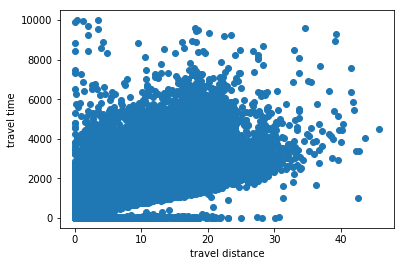

In [99]:
travel2 = df2[["travel_time"]]
plt.plot(T_distance,travel2,'o')
plt.xlabel('travel distance')
plt.ylabel('travel time')

## Haversine Distance ##

In [100]:
def haver(lat_p,lon_p,lat_d,lon_d):
    r=6371
    r_lat_p=np.radians(lat_p)
    r_lon_p=np.radians(lon_p)
    r_lat_d=np.radians(lat_d)
    r_lon_d=np.radians(lon_d)
    dd=np.sin((r_lat_d-r_lat_p)/2)**2+np.cos(r_lat_p)*np.cos(r_lat_d)*np.sin((r_lon_d-r_lon_p)/2)**2
    return(2*r*np.arcsin(np.sqrt(dd)))

In [101]:
pick_lat = df2[["pickup_latitude"]].values
pick_lon = df2[["pickup_longitude"]].values
drop_lat = df2[["dropoff_latitude"]].values
drop_lon = df2[["dropoff_longitude"]].values

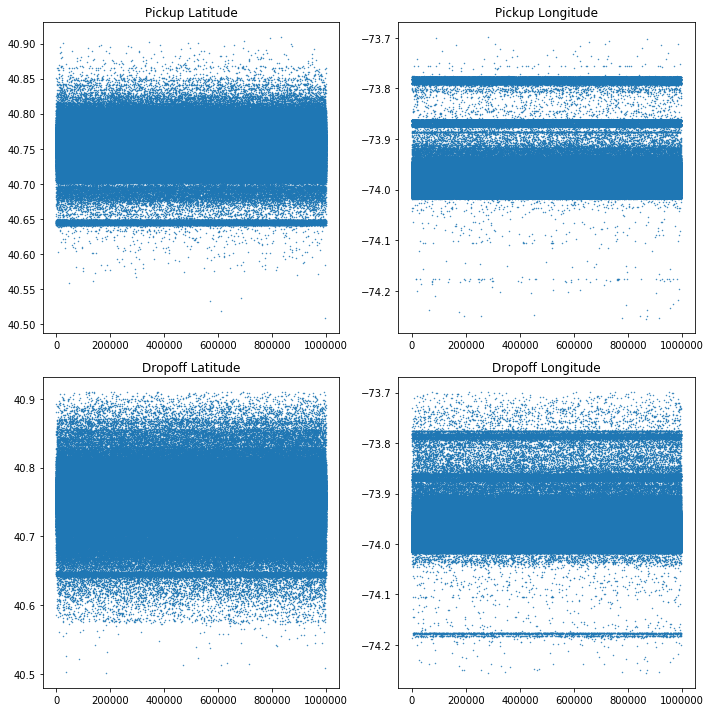

In [102]:
#NYC map https://www.google.com/maps/place/New+York,+NY/@40.7111511,-74.0352615,10.52z/data=!4m5!3m4!1s0x89c24fa5d33f083b:0xc80b8f06e177fe62!8m2!3d40.7127753!4d-74.0059728
fig=plt.figure(figsize=(10,10))
axes=fig.add_subplot(2,2,1)
axes.scatter(np.linspace(1,pick_lat.shape[0],pick_lat.shape[0]),pick_lat,s=0.2)
axes.set_title("Pickup Latitude")
axes=fig.add_subplot(2,2,2)
axes.scatter(np.linspace(1,pick_lon.shape[0],pick_lon.shape[0]),pick_lon,s=0.2)
axes.set_title("Pickup Longitude")
axes=fig.add_subplot(2,2,3)
axes.scatter(np.linspace(1,drop_lat.shape[0],drop_lat.shape[0]),drop_lat,s=0.2)
axes.set_title("Dropoff Latitude")
axes=fig.add_subplot(2,2,4)
axes.scatter(np.linspace(1,drop_lon.shape[0],drop_lon.shape[0]),drop_lon,s=0.2)
axes.set_title("Dropoff Longitude")
plt.tight_layout()

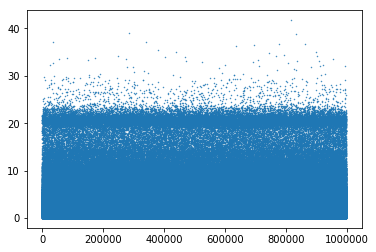

In [103]:
hav_dis=haver(pick_lat,pick_lon,drop_lat,drop_lon)
plt.scatter(np.linspace(1,hav_dis.shape[0],hav_dis.shape[0]),hav_dis,s=0.2)

Text(0, 0.5, 'travel time')

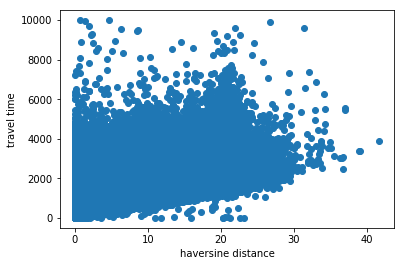

In [104]:
plt.plot(hav_dis,travel2,'o')
plt.xlabel('haversine distance')
plt.ylabel('travel time')

## Pickup/Dropoff Location

### Coordinate of Verrazzano-Narrows Bridge
https://www.google.com/search?q=coordinate+of+Verrazzano-Narrows+Bridge&rlz=1C5CHFA_enUS833US833&oq=coordinate+of+Verrazzano-Narrows+Bridge&aqs=chrome..69i57j33l4.8184j1j7&sourceid=chrome&ie=UTF-8

In [105]:
def zone_class(lat,lon):
    lon_min= -74.2565
    lon_max = -73.6977
    lat_min = 40.4950
    lat_max = 40.9105
    bridge = -74.0447
    
    zone = 0
    macro = ""
    
    if (lon < bridge):
        macro = 'left'
    else:
        macro = 'right'
    
    dlon_left = (bridge - lon_min)/2
    Elithabeth = 40.664
    dlat_left = (Elithabeth - lat_min)/2
    
    if (macro == 'left'):
        if (lon < lon_min+dlon_left):
            if (lat < lat_min+dlat_left):
                zone = 1
            elif (lat < Elithabeth):
                zone = 2
        elif (lon < bridge):
            if (lat < lat_min+dlat_left):
                zone = 3
            elif (lat < Elithabeth):
                zone = 4            
    dlon_right = (lon_max - bridge)/3
    dlat_right = (lat_max - lat_min)/3
    
    if (macro == 'right'):
        if (lon < bridge+dlon_right):
            if (lat < lat_min+dlat_right):
                zone = 5
            elif (lat < lat_min+2*dlat_right):
                zone = 6
            else:
                zone = 7
        elif (lon < bridge+2*dlon_right):
            if (lat < lat_min+dlat_right):
                zone = 8
            elif (lat < lat_min+2* dlat_right):
                zone = 9
            else:
                zone = 10
        elif (lon < lon_max):
            if (lat < lat_min+dlat_right):
                zone = 11
            elif (lat < lat_min+2* dlat_right):
                zone = 12
            else:
                zone = 13
            
    return(zone)

In [106]:
pick_zone = np.empty(pick_lat.shape[0])
for i in range(pick_lat.shape[0]):
    pick_zone[i] = zone_class(pick_lat[i],pick_lon[i])

drop_zone = np.empty(pick_lat.shape[0])
for i in range(pick_lat.shape[0]):
    drop_zone[i] = zone_class(drop_lat[i],drop_lon[i])

In [107]:
# convert into 1,0
n = pick_lat.shape[0]
pick_zone1 = np.zeros([n,13])
for num in range(1,14):
    for i in range(n):
        if (pick_zone[i] == num):
            pick_zone1[i,num-1] = 1

drop_zone1 = np.zeros([n,13])
for num in range(1,14):
    for i in range(n):
        if (drop_zone[i] == num):
            drop_zone1[i,num-1] = 1


## Pickup month/day/hour##

In [108]:
pick_months = df2["mo"]
pick_day = df2["da"]
pick_time_raw = pd.Series.to_frame(df2["pickup_datetime"])

In [109]:
pick_time = []
for i in range(pick_time_raw.shape[0]):
    pick_time.append(np.datetime_as_string(pick_time_raw.values[i][0])[11:18])


In [110]:
pick_hour = []
for i in range(len(pick_time)):
    pick_hour.append(int(pick_time[i][0:2]))

In [111]:
# convert month to 1,0
n = pick_time_raw.shape[0]
months1 = np.zeros([n,12])
m = pick_months.tolist()
for num in range(1,13):
    for i in range(n):
        if (int(m[i]) == num):
            months1[i,num-1] = 1


In [112]:
# convert day to 1,0
n = pick_time_raw.shape[0]
days1 = np.zeros([n,31])
d = pick_day.tolist()
for num in range(1,32):
    for i in range(n):
        if (int(d[i]) == num):
            days1[i,num-1] = 1


In [113]:
# convert hour to 1,0
n = pick_time_raw.shape[0]
hours1 = np.zeros([n,24])
for num in  range(24):
    for i in range(n):
        if (pick_hour[i] == num):
            hours1[i,num] = 1


## Week ##

In [114]:
def weekDay(year, month, day):
    offset = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
    week   = ['Sunday', 
              'Monday', 
              'Tuesday', 
              'Wednesday', 
              'Thursday',  
              'Friday', 
              'Saturday']
    afterFeb = 1
    if month > 2: afterFeb = 0
    aux = year - 1700 - afterFeb
    # dayOfWeek for 1700/1/1 = 5, Friday
    dayOfWeek  = 5
    # partial sum of days betweem current date and 1700/1/1
    dayOfWeek += (aux + afterFeb) * 365                  
    # leap year correction    
    dayOfWeek += aux / 4 - aux / 100 + (aux + 100) / 400     
    # sum monthly and day offsets
    dayOfWeek += offset[month - 1] + (day - 1)               
    dayOfWeek = int(dayOfWeek % 7)
    return week[dayOfWeek]


In [115]:
months = pd.to_numeric(pick_months,downcast='signed')
months = pd.Series.to_frame(months)
days = pd.to_numeric(pick_day,downcast='signed')
days = pd.Series.to_frame(days)

In [116]:
week = []
for i in range(months.shape[0]):
    week.append(weekDay(2016,months.values[i][0],days.values[i][0]))

In [117]:
n = len(week)
names = ['Sunday', 'Monday', 'Tuesday', 'Wednesday','Thursday',  'Friday', 'Saturday']
week1 = np.zeros([n,7])
for num in range(7):
    for i in range(n):
        if (week[i] == names[num]):
            week1[i,num] = 1


## Rush hour##
The rush hour is based on:
https://www.google.com/search?q=rush+hour+in+nyc&rlz=1C5CHFA_enUS833US833&oq=rush+hour+in+NYC&aqs=chrome.0.0l6.3343j0j9&sourceid=chrome&ie=UTF-8

In [118]:
pick_rush = []
for i in range(len(pick_hour)):
    if ((pick_hour[i] >= 7 and pick_hour[i] < 10) or (pick_hour[i] >= 16 and pick_hour[i] < 19)):
        pick_rush.append(1)
    else:
        pick_rush.append(0)

## Weather ##

In [119]:
#tempreture, visibility, precipitation, rain or not, fog or not, snow or not, hail or not, thunder or not
temp = df2[["temp"]].values
visib = df2[["visib"]].values
prcp = df2[["prcp"]].values
rain = df2[["rain_drizzle"]].values
fog = df2[["fog"]].values
snow = df2[["snow_ice_pellets"]].values
hail = df2[["hail"]].values
thunder = df2[["thunder"]].values

## Combine all the variables ##

In [120]:
# convert all the data to the same type
n = T_distance.shape[0]
distance = []
hav = []
tempr = []
visibi = []
prcp1 = []
rain1 = []
fog1 = []
snow1 = []
hail1 = []
thunder1 = []

for i in range(n):
    distance.append(T_distance[i][0])
    hav.append(hav_dis[i][0])
    tempr.append(temp[i][0])
    visibi.append(visib[i][0])
    prcp1.append(prcp[i][0])
    rain1.append(rain[i][0])
    fog1.append(fog[i][0])
    snow1.append(snow[i][0])
    hail1.append(hail[i][0])
    thunder1.append(thunder[i][0])
    
months2 = np.transpose(months1).tolist()
days2 = np.transpose(days1).tolist()
hours2 = np.transpose(hours1).tolist()

In [121]:
myX = pd.DataFrame({"travel distance": distance,"haversine distance": hav,
                   "tempreture": tempr,"visibility": visibi, "precipitation": prcp1,"pickup time in rush": pick_rush,
                    "rain or not": rain1,
                   "fog or not": fog1,"snow or not": snow1,"hail or not": hail1,"thunder ot not": thunder1,
                   "Sunday": week1[:,0],"Monday": week1[:,1],"Tuesday": week1[:,2],"Wednesday": week1[:,3],
                   "Thursday": week1[:,4],"Friday": week1[:,5],"pick zone1": pick_zone1[:,0],"pick zone2": pick_zone1[:,1],"pick zone3": pick_zone1[:,2],
                   "pick zone4": pick_zone1[:,3],"pick zone5": pick_zone1[:,4],"pick zone6": pick_zone1[:,5],
                    "pick zone7": pick_zone1[:,6],"pick zone8": pick_zone1[:,7],"pick zone9": pick_zone1[:,8],
                   "pick zone10": pick_zone1[:,9],"pick zone11": pick_zone1[:,10],"pick zone12": pick_zone1[:,11],
                   "drop zone1": drop_zone1[:,0],"drop zone2": drop_zone1[:,1],
                    "drop zone3": drop_zone1[:,2],"drop zone4": drop_zone1[:,3],"drop zone5": drop_zone1[:,4],
                    "drop zone6": drop_zone1[:,5],
                    "drop zone7": drop_zone1[:,6],"drop zone8": drop_zone1[:,7],"drop zone9": drop_zone1[:,8],
                   "drop zone10": drop_zone1[:,9],"drop zone11": drop_zone1[:,10],"drop zone12": drop_zone1[:,11],
                    "Jan": months2[0],"Feb": months2[1],"Mar": months2[2],"Apr": months2[3],"May": months2[4],
                   "Jun": months2[5],"Jul": months2[6],"Aug": months2[7],"Sep": months2[8],"Oct": months2[9],
                   "Nov": months2[10],"day1":days2[0],"day2":days2[1],"day3":days2[2],
                   "day4":days2[3],"day5":days2[4],"day6":days2[5],"day7":days2[6],"day8":days2[7],
                    "day9":days2[8],"day10":days2[9],"day11":days2[10],"day12":days2[11],"day13":days2[12],
                   "day14":days2[13],"day15":days2[14],"day16":days2[15],"day17":days2[16],"day18":days2[17],
                   "day19":days2[18],"day20":days2[19],"day21":days2[20],"day22":days2[21],"day23":days2[22],
                   "day24":days2[23],"day25":days2[24],"day26":days2[25],"day27":days2[26],"day28":days2[27],
                   "day29":days2[28],"day30":days2[29],"hour0":hours2[0],"hour1":hours2[1],"hour2":hours2[2],
                   "hour3":hours2[3],"hour4":hours2[4],"hour5":hours2[5],"hour6":hours2[6],"hour7":hours2[7],
                   "hour8":hours2[8],"hour9":hours2[9],"hour10":hours2[10],"hour11":hours2[11],
                    "hour12":hours2[12],"hour13":hours2[13],"hour14":hours2[14],"hour15":hours2[15],
                   "hour16":hours2[16],"hour17":hours2[17],"hour18":hours2[18],"hour19":hours2[19],
                    "hour20":hours2[20],"hour21":hours2[21],"hour22":hours2[22]})
myX.head()

,travel distance,haversine distance,tempreture,visibility,precipitation,pickup time in rush,rain or not,fog or not,snow or not,hail or not,thunder ot not,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,pick zone1,pick zone2,pick zone3,pick zone4,pick zone5,pick zone6,pick zone7,pick zone8,pick zone9,pick zone10,pick zone11,pick zone12,drop zone1,drop zone2,drop zone3,drop zone4,drop zone5,drop zone6,drop zone7,drop zone8,drop zone9,drop zone10,drop zone11,drop zone12,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,day1,day2,day3,day4,day5,day6,day7,day8,day9,day10,day11,day12,day13,day14,day15,day16,day17,day18,day19,day20,day21,day22,day23,day24,day25,day26,day27,day28,day29,day30,hour0,hour1,hour2,hour3,hour4,hour5,hour6,hour7,hour8,hour9,hour10,hour11,hour12,hour13,hour14,hour15,hour16,hour17,hour18,hour19,hour20,hour21,hour22
0,0.25,0.437545,75.3,8.3,0.00,1,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.70,1.003917,47.3,10.0,0.09,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.21,2.490037,44.5,10.0,0.01,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.90,2.247781,54.9,6.8,0.17,1,1,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.50,0.656740,34.8,7.5,0.01,0,0,0,1,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
myY=df2[["travel_time"]]

# Model selection

In [123]:
AM0=sum(myX['hour0'])
AM1=sum(myX['hour1'])
AM2=sum(myX['hour2'])
AM3=sum(myX['hour3'])
AM4=sum(myX['hour4'])
AM5=sum(myX['hour5'])
AM6=sum(myX['hour6'])
AM7=sum(myX['hour7'])
AM8=sum(myX['hour8'])
AM9=sum(myX['hour9'])
AM10=sum(myX['hour10'])
AM11=sum(myX['hour11'])
PM0=sum(myX['hour12'])
PM1=sum(myX['hour13'])
PM2=sum(myX['hour14'])
PM3=sum(myX['hour15'])
PM4=sum(myX['hour16'])
PM5=sum(myX['hour17'])
PM6=sum(myX['hour18'])
PM7=sum(myX['hour19'])
PM8=sum(myX['hour20'])
PM9=sum(myX['hour21'])
PM10=sum(myX['hour22'])
performance = [AM0,AM1,AM2,AM3,AM4,AM5,AM6,AM7,AM8,AM9,AM10,AM11,PM0,PM1,PM2,PM3,PM4,PM5,PM6,PM7,PM8,PM9,PM10]
Sun=sum(myX['Sunday'])
Mo=sum(myX['Monday'])
Tue=sum(myX['Tuesday'])
Wed=sum(myX['Wednesday'])
Thr=sum(myX['Thursday'])
Fri=sum(myX['Friday'])
we = [Sun,Mo,Tue,Wed,Thr,Fri]

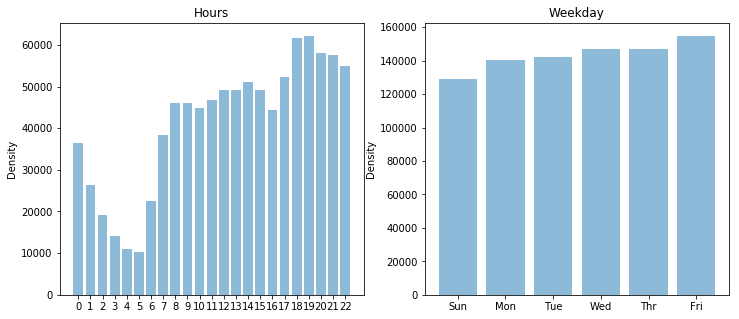

In [124]:
#

hours = ('0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22')
day = ('Sun','Mon','Tue','Wed','Thr','Fri')

plt.show()
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.bar(hours, performance, align='center', alpha=0.5)
plt.ylabel('Density')
plt.title('Hours')

plt.subplot(1,2,2)
plt.bar(day, we, align='center', alpha=0.5)
plt.ylabel('Density')
plt.title('Weekday')
plt.show()

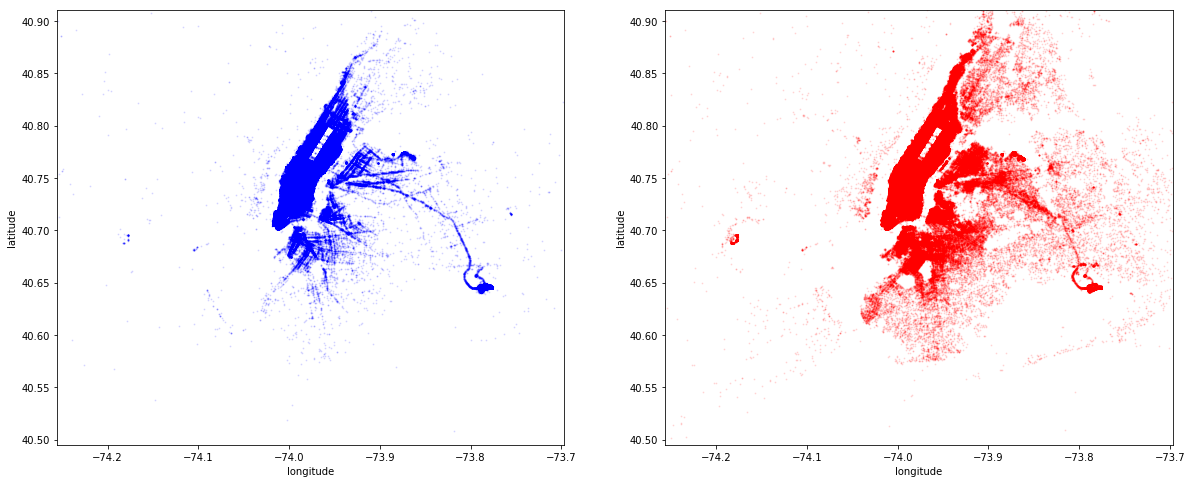

In [125]:

# Plot pick up and drop off coordinates

plt.figure(figsize=(20,8))
city_long = (-74.256, -73.697)
city_lat = (40.4950, 40.9105)
plt.subplot(1,2,1)
plt.scatter(df2['pickup_longitude'].values, df2['pickup_latitude'].values,color='blue', s=1, alpha=0.1)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat)
plt.xlim(city_long)
plt.subplot(1,2,2)
plt.scatter(df2['dropoff_longitude'].values,df2['dropoff_latitude'].values,color='red', s=1, alpha=0.1)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat)
plt.xlim(city_long)
plt.show()

WE can see the pickup/dropoff locations are mainly aound Manhattan area.

In [126]:
def rmsle(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0:
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

## Model  : Lasso Regression## 

In [127]:
X_train, X_test, y_train, y_test = train_test_split(myX.iloc[:,:].values, myY.iloc[:,:].values)
X_train = np.array(X_train, dtype='float')
X_test = np.array(X_test, dtype='float')

In [86]:
from sklearn import preprocessing
import sklearn
x=myX.iloc[:,:]
y=myY.iloc[:,:]
X_scaled = preprocessing.scale(myX.iloc[:,:].values)
y_scaled = y - np.mean(myY.iloc[:,:].values)
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_scaled,test_size=0.2, random_state=np.random )

clf = sklearn.linear_model.Lasso(alpha = 0.7)
clf.fit(X_train,y_train)
print(clf.score(X_test,y_test))
print(clf.predict(X_test))

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


0.6864140683068989
[-558.64397024  -95.86681463 -204.76282414 ...   84.53790248 -435.56518243
 -168.39791244]


# Random Forest

In [88]:

params = {"n_estimators": np.arange(50,150,10),"max_depth": np.arange(2,10,1)}

search = RandomizedSearchCV(RandomForestRegressor(), param_distributions=params, random_state=0, n_iter=10, cv=3, verbose=1, 
                            n_jobs=-1, return_train_score=True)

search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.8min finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140]), 'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9])},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score=True, scoring=None, verbose=1)

In [89]:
y_pred = search.predict(X_test)
y_t = y_test
r2_v2 = r2_score(y_t,y_pred)
rmse_v2 = math.sqrt(mean_squared_error(y_t,y_pred))
rmsle_v2 = rmsle(y_t,y_pred)

pd.DataFrame({'R2':[r2_v2],'RMSE':[rmse_v2],'RMSLE':[rmsle_v2]})

,R2,RMSE,RMSLE
0,0.731005,335.560499,[0.39707607172222564]


## Model : Neoral Network ##

In [ ]:
#x=myX.iloc[:,:]
#y#=myY.iloc[:,:]
#y=np.reshape(y, (-1,1))
#scaler = MinMaxScaler()
#print(scaler.fit(x))
#print(scaler.fit(y))
#xscale=pd.DataFrame(np.array([np.arange(myX.shape[0])]*myX.shape[0]).T,columns=myX.columns)
#xscale.iloc[:,0:5]=scaler.transform(x.iloc[:,0:5])
#xscale.iloc[:,5:myX.shape[1]]=x.iloc[:,5:myX.shape[1]]
#yscale=scaler.transform(y)
#X_train, X_test, y_train, y_test = train_test_split(xscale, yscale)
#X_train = np.array(X_train, dtype='float')
#X_test = np.array(X_test, dtype='float'#)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


In [ ]:
## Python program to implement a  
## single neuron neural network 
  
## import all necessery libraries 
#from numpy import exp, array, random, dot, tanh 
  
## Class to create a neural  
## network with single neuron 
#class NeuralNetwork(): 
#      
#    def __init__(self): 
#          
#        # Using seed to make sure it'll   
#        # generate same weights in every run 
#        random.seed(1) 
#          
#        # 3x1 Weight matrix 
#        self.weight_matrix = 2 * random.random((X_train.shape[1], 1)) - 1
#  
#    # tanh as activation fucntion 
#    def tanh(self, x): 
#        return tanh(x) 
#  
#    # derivative of tanh function. 
#    # Needed to calculate the gradients. 
#    def tanh_derivative(self, x): 
#        return 1.0 - tanh(x) ** 2
#  
#    # forward propagation 
#    def forward_propagation(self, inputs): 
#        return self.tanh(dot(inputs, self.weight_matrix)) 
#      
#    # training the neural network. 
#    def train(self, train_inputs, train_outputs, 
#                            num_train_iterations): 
#                                 
#        # Number of iterations we want to 
#        # perform for this set of input. 
#        for iteration in range(num_train_iterations): 
#            output = self.forward_propagation(train_inputs) 
#            # Calculate the error in the output. 
#            error = train_outputs - output 
#  
#            # multiply the error by input and then  
#            # by gradient of tanh funtion to calculate 
#            # the adjustment needs to be made in weights 
#            adjustment = dot(train_inputs.T, error *
#                             self.tanh_derivative(output)) 
#                               
#            # Adjust the weight matrix 
#            self.weight_matrix += adjustment 
#  
## Driver Code 
#if __name__ == "__main__": 
#      
#    neural_network = NeuralNetwork() 
#      
#    print ('Random weights at the start of training') 
#    #print (neural_network.weight_matrix) 
#  
#    train_inputs = X_train 
#    train_outputs = y_train
#  
#    neural_network.train(train_inputs, train_outputs, 1000) 
#    yy=neural_network.forward_propagation(X_test)
#    print ('New weights after training') 
#    #print (neural_network.weight_matrix) 
#  
#    # Test the neural network with a new situation. 
#    print ("Testing network on new examples ->") 
#    #print (neural_network.forward_propagation(array([1, 0, 0]))) 

In [3]:
#import numpy as np
#
#class NeuralNetwork():
#    
#    def __init__(self):
#        # seeding for random number generation
#        np.random.seed(1)
#        
#        #converting weights to a 105 by 1 matrix with values from -1 to 1 and mean of 0
#        self.synaptic_weights = 2 * np.random.random((X_train.shape[1], 1)) - 1
#
#    def sigmoid(self, x):
#        #applying the sigmoid function
#        return 1 / (1 + np.exp(-x))
#
#    def sigmoid_derivative(self, x):
#        #computing derivative to the Sigmoid function
#        return x * (1 - x)
#
#    def train(self, training_inputs, training_outputs, training_iterations):
#        
#        #training the model to make accurate predictions while adjusting weights continually
#        for iteration in range(training_iterations):
#            #siphon the training data via  the neuron
#            output = self.think(training_inputs)
#
#            #computing error rate for back-propagation
#            error = training_outputs - output
#            
#            #performing weight adjustments
#            adjustments = np.dot(training_inputs.T, error * self.sigmoid_derivative(output))
#
#            self.synaptic_weights += adjustments
#
#    def think(self, inputs):
#        #passing the inputs via the neuron to get output   
#        #converting values to floats
#        
#        inputs = inputs.astype(float)
#        output = self.sigmoid(np.dot(inputs, self.synaptic_weights))
#        return output
#
#
#if __name__ == "__main__":
#
#    #initializing the neuron class
#    neural_network = NeuralNetwork()
#    print("Beginning Randomly Generated Weights: ")
#    print(neural_network.synaptic_weights)
#    #training data consisting of 4 examples--3 input values and 1 output
#    training_inputs = X_train
#    training_outputs = y_train
#    #training taking place
#    neural_network.train(training_inputs, training_outputs, 15000)
#    print("Ending Weights After Training: ")
#    print(neural_network.synaptic_weights)
#
#    yy=neural_network.think(X_test)

In [38]:
#plt.scatter(yy,y_test)

In [34]:
#model = Sequential()
#model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
#model.add(Dense(5, activation='relu'))
#model.add(Dense(1, activation='linear'))
#model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                1060      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


Our Neural Network Model didn't work on Jupyter note, so we tried on R.studio and it provided us very good outcomes, so we keep it as an R.markdown file on the final project folder and upload it to github.

## Try Neural network in R##

In [286]:
myX.to_csv(r'/Users/fizz/Downloads/Final/myX.csv')
myY.to_csv(r'/Users/fizz/Downloads/Final/myY.csv')

## Predicting using testing data##

In [39]:
test2015 = pd.read_csv('/Users/fizz/Downloads/APM4990_final_test_data_filtered.csv')
test2015.head()

,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count
0,2015-06-18 21:52:45+00:00,40.702740,-74.011650,40.773361,-73.990311,5
1,2015-11-08 02:22:25+00:00,40.733608,-74.003098,40.836803,-73.941643,1
2,2015-02-13 04:11:11+00:00,40.730911,-74.001442,40.665699,-73.956909,1
3,2015-07-23 09:14:04+00:00,40.774078,-73.874550,40.749939,-73.991203,2
4,2015-01-07 18:06:43+00:00,40.791588,-73.964874,40.792084,-73.968254,2


## Import weather data##

In [40]:
query = (
    """
     select year,mo,da,temp,visib
     prcp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,visib
     from `bigquery-public-data.noaa_gsod.gsod2015` where stn='725053'
    """
)
weather2015=pd.io.gbq.read_gbq(query,dialect='standard')
weather2015.head()

,year,mo,da,temp,prcp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,visib
0,2015,03,10,47.2,8.5,0,1,0,0,0,8.5
1,2015,12,31,46.5,5.4,0,1,0,0,0,5.4
2,2015,11,30,39.4,999.9,0,0,0,0,0,999.9
3,2015,01,07,20.7,9.7,0,0,0,0,0,9.7
4,2015,01,15,29.5,10.0,0,0,0,0,0,10.0


In [41]:
# haversine distence
pick_lat = test2015[["pickup_latitude"]].values
pick_lon = test2015[["pickup_longitude"]].values
drop_lat = test2015[["dropoff_latitude"]].values
drop_lon = test2015[["dropoff_longitude"]].values
hav_dis=haver(pick_lat,pick_lon,drop_lat,drop_lon)

In [42]:
# Pick.drop location
pick_zone = np.empty(pick_lat.shape[0])
for i in range(pick_lat.shape[0]):
    pick_zone[i] = zone_class(pick_lat[i],pick_lon[i])

drop_zone = np.empty(pick_lat.shape[0])
for i in range(pick_lat.shape[0]):
    drop_zone[i] = zone_class(drop_lat[i],drop_lon[i])

# convert into 1,0
n = pick_lat.shape[0]
pick_zone1 = np.zeros([n,13])
for num in range(1,14):
    for i in range(n):
        if (pick_zone[i] == num):
            pick_zone1[i,num-1] = 1

drop_zone1 = np.zeros([n,13])
for num in range(1,14):
    for i in range(n):
        if (drop_zone[i] == num):
            drop_zone1[i,num-1] = 1
   

In [43]:
# Pickup month, day, hour
pick_time_raw = pd.Series.to_frame(test2015["pickup_datetime"]).values
n_year = 4
n_month = 2
n_date = 2
n_hour = 2

years = []
months = []
days = []
hours = []

for i in range(pick_time_raw.shape[0]):
    years.append(pick_time_raw[i][0][:n_year])
    months.append(pick_time_raw[i][0][5:n_month+5])
    days.append (pick_time_raw [i][0][8:n_date+8])
    hours.append ( pick_time_raw [i][0][11:n_hour+11])

# convert month to 1,0
n = pick_time_raw.shape[0]
months1 = np.zeros([n,12])
for num in range(1,13):
    for i in range(n):
        if (int(months[i]) == num):
            months1[i,num-1] = 1

# convert day to 1,0
n = pick_time_raw.shape[0]
days1 = np.zeros([n,31])
for num in range(1,32):
    for i in range(n):
        if (int(days[i]) == num):
            days1[i,num-1] = 1
# convert hour to 1,0
n = pick_time_raw.shape[0]
hours1 = np.zeros([n,24])
for num in range(24):
    for i in range(n):
        if (hours[i] == num):
            hours1[i,num] = 1


In [44]:
# Week 
months = pd.to_numeric(months,downcast='signed')
days = pd.to_numeric(days,downcast='signed')

week = []
for i in range(months.shape[0]):
    week.append(weekDay(2015,months[i],days[i]))

n = len(week)
names = ['Sunday', 'Monday', 'Tuesday', 'Wednesday','Thursday',  'Friday', 'Saturday']
week1 = np.zeros([n,7])
for num in range(7):
    for i in range(n):
        if (week[i] == names[num]):
            week1[i,num] = 1


In [45]:
# Rush hour

pick_rush = []
for i in range(len(hours)):
    if ((int(hours[i]) >= 7 and int(hours[i])  < 10) or (int(hours[i])  >= 16 and int(hours[i])  < 19)):
        pick_rush.append(1)
    else:
        pick_rush.append(0)

In [46]:
# Weather
test2015["mo"] = months
test2015["da"] =days
w_months = []
w_days = []
for i in range(weather2015.values.shape[0]):
    w_months.append(int(weather2015[["mo"]].values[i][0]))
    w_days.append(int(weather2015[["da"]].values[i][0]))
weather2015["mo2"] = w_months
weather2015["da2"] = w_days

test1_2015 = test2015.merge(weather2015, how='left', left_on=["mo", "da"], right_on=["mo2","da2"]) 
test1_2015.head()

,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,mo_x,da_x,year,mo_y,da_y,temp,prcp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,visib,mo2,da2
0,2015-06-18 21:52:45+00:00,40.702740,-74.011650,40.773361,-73.990311,5,6,18,2015,06,18,66.8,9.8,0,0,0,0,0,9.8,6,18
1,2015-11-08 02:22:25+00:00,40.733608,-74.003098,40.836803,-73.941643,1,11,8,2015,11,08,51.9,10.0,0,0,0,0,0,10.0,11,8
2,2015-02-13 04:11:11+00:00,40.730911,-74.001442,40.665699,-73.956909,1,2,13,2015,02,13,16.1,10.0,0,0,0,0,0,10.0,2,13
3,2015-07-23 09:14:04+00:00,40.774078,-73.874550,40.749939,-73.991203,2,7,23,2015,07,23,76.7,10.0,0,0,0,0,0,10.0,7,23
4,2015-01-07 18:06:43+00:00,40.791588,-73.964874,40.792084,-73.968254,2,1,7,2015,01,07,20.7,9.7,0,0,0,0,0,9.7,1,7


In [47]:
temp = test1_2015[["temp"]].values
visib = test1_2015[["visib"]].values
prcp = test1_2015[["prcp"]].values
rain = test1_2015[["rain_drizzle"]].values
fog = test1_2015[["fog"]].values
snow = test1_2015[["snow_ice_pellets"]].values
hail = test1_2015[["hail"]].values
thunder = test1_2015[["thunder"]].values

In [48]:
#T_distance 
T_distance = []
n = pick_lat.shape[0]
for i in range(n):
    T_distance.append(69*np.abs(pick_lat[i][0]-drop_lat[i][0])+52.5*np.abs(pick_lon[i][0]-drop_lon[i][0] ))

In [49]:

distance = T_distance
hav = []
tempr = []
visibi = []
prcp1 = []
rain1 = []
fog1 = []
snow1 = []
hail1 = []
thunder1 = []

for i in range(n):
    hav.append(hav_dis[i][0])
    tempr.append(temp[i][0])
    visibi.append(visib[i][0])
    prcp1.append(prcp[i][0])
    rain1.append(rain[i][0])
    fog1.append(fog[i][0])
    snow1.append(snow[i][0])
    hail1.append(hail[i][0])
    thunder1.append(thunder[i][0])
    
months2 = np.transpose(months1).tolist()
days2 = np.transpose(days1).tolist()
hours2 = np.transpose(hours1).tolist()

In [50]:
myXtest = pd.DataFrame({"travel distance": distance,"haversine distance": hav,
                   "tempreture": tempr,"visibility": visibi, "precipitation": prcp1,"pickup time in rush": pick_rush,
                    "rain or not": rain1,
                   "fog or not": fog1,"snow or not": snow1,"hail or not": hail1,"thunder ot not": thunder1,
                   "Sunday": week1[:,0],"Monday": week1[:,1],"Tuesday": week1[:,2],"Wednesday": week1[:,3],
                   "Thursday": week1[:,4],"Friday": week1[:,5],"pick zone1": pick_zone1[:,0],"pick zone2": pick_zone1[:,1],"pick zone3": pick_zone1[:,2],
                   "pick zone4": pick_zone1[:,3],"pick zone5": pick_zone1[:,4],"pick zone6": pick_zone1[:,5],
                    "pick zone7": pick_zone1[:,6],"pick zone8": pick_zone1[:,7],"pick zone9": pick_zone1[:,8],
                   "pick zone10": pick_zone1[:,9],"pick zone11": pick_zone1[:,10],"pick zone12": pick_zone1[:,11],
                   "drop zone1": drop_zone1[:,0],"drop zone2": drop_zone1[:,1],
                    "drop zone3": drop_zone1[:,2],"drop zone4": drop_zone1[:,3],"drop zone5": drop_zone1[:,4],
                    "drop zone6": drop_zone1[:,5],
                    "drop zone7": drop_zone1[:,6],"drop zone8": drop_zone1[:,7],"drop zone9": drop_zone1[:,8],
                   "drop zone10": drop_zone1[:,9],"drop zone11": drop_zone1[:,10],"drop zone12": drop_zone1[:,11],
                    "Jan": months2[0],"Feb": months2[1],"Mar": months2[2],"Apr": months2[3],"May": months2[4],
                   "Jun": months2[5],"Jul": months2[6],"Aug": months2[7],"Sep": months2[8],"Oct": months2[9],
                   "Nov": months2[10],"day1":days2[0],"day2":days2[1],"day3":days2[2],
                   "day4":days2[3],"day5":days2[4],"day6":days2[5],"day7":days2[6],"day8":days2[7],
                    "day9":days2[8],"day10":days2[9],"day11":days2[10],"day12":days2[11],"day13":days2[12],
                   "day14":days2[13],"day15":days2[14],"day16":days2[15],"day17":days2[16],"day18":days2[17],
                   "day19":days2[18],"day20":days2[19],"day21":days2[20],"day22":days2[21],"day23":days2[22],
                   "day24":days2[23],"day25":days2[24],"day26":days2[25],"day27":days2[26],"day28":days2[27],
                   "day29":days2[28],"day30":days2[29],"hour0":hours2[0],"hour1":hours2[1],"hour2":hours2[2],
                   "hour3":hours2[3],"hour4":hours2[4],"hour5":hours2[5],"hour6":hours2[6],"hour7":hours2[7],
                   "hour8":hours2[8],"hour9":hours2[9],"hour10":hours2[10],"hour11":hours2[11],
                    "hour12":hours2[12],"hour13":hours2[13],"hour14":hours2[14],"hour15":hours2[15],
                   "hour16":hours2[16],"hour17":hours2[17],"hour18":hours2[18],"hour19":hours2[19],
                    "hour20":hours2[20],"hour21":hours2[21],"hour22":hours2[22]})
myXtest.head()

,travel distance,haversine distance,tempreture,visibility,precipitation,pickup time in rush,rain or not,fog or not,snow or not,hail or not,thunder ot not,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,pick zone1,pick zone2,pick zone3,pick zone4,pick zone5,pick zone6,pick zone7,pick zone8,pick zone9,pick zone10,pick zone11,pick zone12,drop zone1,drop zone2,drop zone3,drop zone4,drop zone5,drop zone6,drop zone7,drop zone8,drop zone9,drop zone10,drop zone11,drop zone12,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,day1,day2,day3,day4,day5,day6,day7,day8,day9,day10,day11,day12,day13,day14,day15,day16,day17,day18,day19,day20,day21,day22,day23,day24,day25,day26,day27,day28,day29,day30,hour0,hour1,hour2,hour3,hour4,hour5,hour6,hour7,hour8,hour9,hour10,hour11,hour12,hour13,hour14,hour15,hour16,hour17,hour18,hour19,hour20,hour21,hour22
0,5.993202,8.055939,66.8,9.8,9.8,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.346844,12.587349,51.9,10.0,10.0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6.837616,8.165491,16.1,10.0,10.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7.789925,10.184872,76.7,10.0,10.0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.211658,0.289822,20.7,9.7,9.7,1,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
myXtest.to_csv(r'/Users/fizz/Downloads/Final/myXtest.csv')

## Predictions: regresssion ##

In [52]:
predictions = clf.predict(myXtest)
predictions

array([4196.6784588 , 6851.58841513, 4625.69649309, ..., 4054.76167464,
        665.53452658, 7217.67975923])

## Our final predicitions are in the csv file##